In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler

/Users/pranikchainani/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/pranikchainani/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/pranikchainani/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/pranikchainani/anaconda3/lib/python3.6/site-pack

In [2]:
def resting_heart_rate(heart_rate, steps):
    df_hr = pd.read_csv(heart_rate)
    df_hr = df_hr.set_index('datetime')
    df_hr.index.name = None
    df_hr.index = pd.to_datetime(df_hr.index)

    # steps data
    df_steps = pd.read_csv(steps)
    df_steps = df_steps.set_index('datetime')
    df_steps.index.name = None
    df_steps.index = pd.to_datetime(df_steps.index)

    # merge heartrate and steps
    df1 = pd.merge(df_hr, df_steps, left_index=True, right_index=True)
    df1 = df1.resample('1min').mean() # resample to 1min resolution
    df1 = df1.dropna()

    # define RHR as the HR measurements recorded when there were zero steps taken during a rolling time window of the preceding 12 minutes (including the current minute)
    df1['steps_window_12'] = df1['steps'].rolling(12).sum()
    df1 = df1.loc[(df1['steps_window_12'] == 0)]
    
    return df1

In [3]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("./COVID-19-Wearables/") if isfile(join("./COVID-19-Wearables/", f))]

In [145]:
filenames = []
for filename in onlyfiles:
    filenames.append(filename.split(".")[0])

In [146]:
curr_filenames = []
invalid_files = ['AJWW3IY', 'AOYM4KG', 'A0VFT1N', 'A4G0044', 'AA2KP1S', 'AYWIEKR',
       'A1K5DRI', 'AAXAA7Z', 'AIFDJZB', 'AKXN5ZZ', 'AMV7EQF', 'A7EM0B6',
       'AYEFCWQ', 'A3OU183', 'AX6281V', 'A4E0D03', 'AS2MVDL', 'ASFODQR',
       'A0NVTRV', 'AHYIJDV', 'AQC0L71', 'AV2GF3B', 'APGIB2T', 'A3ADWUT']
for filename in filenames:
    if filename.split("_")[0] not in invalid_files:
        curr_filenames.append(filename)
filenames = curr_filenames

In [149]:
hr_names = []
steps_names = []

for file in filenames:
    if "hr" in file:
        hr_names.append(file)
    elif "steps" in file:
        steps_names.append(file)

In [150]:
hr_files = sorted(hr_files)
steps_files = sorted(steps_files)

In [215]:
# Pre-processing ------------------------------------------------------
def pre_processing(resting_heart_rate):
    """
    This function takes resting heart rate data and applies moving averages to smooth the data and 
    downsamples to one hour by taking the avegare values
    """
    df1 = resting_heart_rate

    # smooth data
    df_nonas = df1.dropna()
    #df1_rom = df_nonas.rolling(400).mean()
    # resample
    df1_resmp = df_nonas.resample('1H').mean()
    df2 = df1_resmp.drop(['steps', 'steps_window_12'], axis=1)
    df2 = df2.dropna()
    return df2

# Seasonality correction ------------------------------------------------------
def seasonality_correction(resting_heart_rate):
    """
    This function takes output pre-processing and applies seasonality correction
    """
    sdHR = resting_heart_rate

    sdHR_decomposition = seasonal_decompose(sdHR, model='additive', freq=1)
    sdHR_decomp = pd.DataFrame(sdHR_decomposition.resid + sdHR_decomposition.trend)
    sdHR_decomp.rename(columns={sdHR_decomp.columns[0]:'heartrate'}, inplace=True)

    return sdHR_decomp

In [216]:
hr_names = sorted(hr_names)
steps_names = sorted(steps_names)

In [217]:
data_set = []

for i in range(len(hr_names)):
    hr_csv = "./COVID-19-Wearables/" + hr_names[i] + ".csv"
    steps_csv = "./COVID-19-Wearables/" + steps_names[i] + ".csv"
    print(hr_names[i], steps_names[i], i)
    
    current_df = resting_heart_rate(hr_csv, steps_csv) + 0.1
    processed_df = seasonality_correction(pre_processing(current_df))
    
    standardizer = StandardScaler().fit(processed_df.values)
    data_train_scaled = standardizer.transform(processed_df.values)
    
    data_set.append(data_train_scaled)

A06L7KF_hr A06L7KF_steps 0
A0822M0_hr A0822M0_steps 1
A0KX894_hr A0KX894_steps 2
A0L9BM2_hr A0L9BM2_steps 3
A0N9NV4_hr A0N9NV4_steps 4
A11SQQN_hr A11SQQN_steps 5
A11V1FH_hr A11V1FH_steps 6
A17YCA2_hr A17YCA2_steps 7
A1ZJ41O_hr A1ZJ41O_steps 8
A2D7K4A_hr A2D7K4A_steps 9
A2P3LTM_hr A2P3LTM_steps 10
A2XFW2N_hr A2XFW2N_steps 11
A35BJNV_hr A35BJNV_steps 12
A36HR6Y_hr A36HR6Y_steps 13
A45F9E6_hr A45F9E6_steps 14
A4H7SNF_hr A4H7SNF_steps 15
A5XL2IC_hr A5XL2IC_steps 16
A65HVGP_hr A65HVGP_steps 17
A6BUI4N_hr A6BUI4N_steps 18
A6GEBIK_hr A6GEBIK_steps 19
A7EAWA7_hr A7EAWA7_steps 20
A8CBEJZ_hr A8CBEJZ_steps 21
A8QLAB0_hr A8QLAB0_steps 22
A91HEZV_hr A91HEZV_steps 23
A99ZKKW_hr A99ZKKW_steps 24
A9ZG5GR_hr A9ZG5GR_steps 25
AA0HAI1_1_hr AA0HAI1_1_steps 26
AA0HAI1_2_hr AA0HAI1_2_steps 27
AA0HAI1_3_hr AA0HAI1_3_steps 28
AAF9ACE_hr AAF9ACE_steps 29
AAGTWZK_hr AAGTWZK_steps 30
AD77K91_hr AD77K91_steps 31
AE0MQ94_hr AE0MQ94_steps 32
AE2B3RH_hr AE2B3RH_steps 33
AEOBCFJ_hr AEOBCFJ_steps 34
AEOHH30_hr AEOHH30

In [233]:
combined_data = np.vstack(data_set); combined_data.shape

(77487, 1)

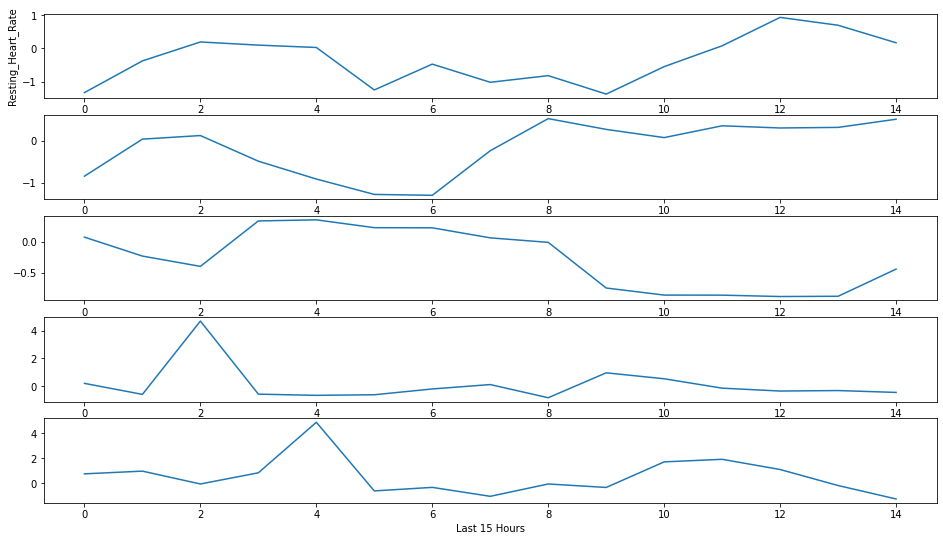

In [261]:
plt.figure(figsize=(16, 9))
for i in range(5):
    randindex = np.random.randint(len(data_set))
    plt.subplot(5, 1, i+1)
    plt.xlabel("Last 15 Hours")
    if i == 0:
        plt.ylabel("Resting_Heart_Rate")
    plt.plot(np.arange(0, len(data_set[randindex][-15:])), data_set[randindex][-15:])

In [281]:
window_size = 15
input_arr = []
output_arr = []
for i in range(0, len(combined_data)-15, 15):
    curr_input = []
    for j in range(window_size-1):
        curr_input.append(combined_data[i+j])
    input_arr.append(curr_input)
    output_arr.append(combined_data[i+j+1])

In [286]:
input_arr = np.array(input_arr); input_arr.shape

(5165, 14, 1)

In [289]:
output_arr = np.array(output_arr); output_arr.shape

(5165, 1)

In [346]:
train_input = input_arr[:3000]
train_output = output_arr[:3000]

In [362]:
MAX_EPOCHS = 100

def compile_and_fit(model, input_mat, output_mat, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss='mse',
                optimizer='Adam',
                metrics=['mae'])

    history = model.fit(x=input_mat, y=output_mat, epochs=MAX_EPOCHS)
    return history

In [363]:
dense = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(3,),
                           activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

history = compile_and_fit(dense, input_mat=np.array(train_input), output_mat=train_output)

Epoch 1/100
3000/3000 [==============================] - 1s 274us/step - loss: 0.8124 - mean_absolute_error: 0.6534
Epoch 2/100
3000/3000 [==============================] - 0s 78us/step - loss: 0.7413 - mean_absolute_error: 0.6071
Epoch 3/100
3000/3000 [==============================] - 0s 74us/step - loss: 0.7171 - mean_absolute_error: 0.5986
Epoch 4/100
3000/3000 [==============================] - 0s 74us/step - loss: 0.7028 - mean_absolute_error: 0.5939
Epoch 5/100
3000/3000 [==============================] - 0s 72us/step - loss: 0.6889 - mean_absolute_error: 0.5828
Epoch 6/100
3000/3000 [==============================] - 0s 104us/step - loss: 0.6846 - mean_absolute_error: 0.5837
Epoch 7/100
3000/3000 [==============================] - 0s 74us/step - loss: 0.6708 - mean_absolute_error: 0.5781
Epoch 8/100
3000/3000 [==============================] - 0s 81us/step - loss: 0.6723 - mean_absolute_error: 0.5792
Epoch 9/100
3000/3000 [==============================] - 0s 76us/step - loss: 

3000/3000 [==============================] - 0s 81us/step - loss: 0.2293 - mean_absolute_error: 0.3562
Epoch 71/100
3000/3000 [==============================] - 0s 71us/step - loss: 0.2150 - mean_absolute_error: 0.3426
Epoch 72/100
3000/3000 [==============================] - 0s 62us/step - loss: 0.2165 - mean_absolute_error: 0.3456
Epoch 73/100
3000/3000 [==============================] - 0s 68us/step - loss: 0.2134 - mean_absolute_error: 0.3393
Epoch 74/100
3000/3000 [==============================] - 0s 73us/step - loss: 0.2169 - mean_absolute_error: 0.3460
Epoch 75/100
3000/3000 [==============================] - 0s 81us/step - loss: 0.2193 - mean_absolute_error: 0.3496
Epoch 76/100
3000/3000 [==============================] - 0s 77us/step - loss: 0.2303 - mean_absolute_error: 0.3542
Epoch 77/100
3000/3000 [==============================] - 0s 72us/step - loss: 0.2217 - mean_absolute_error: 0.3476
Epoch 78/100
3000/3000 [==============================] - 0s 98us/step - loss: 0.1948

In [364]:
test_input = input_arr[3000:]
test_output = output_arr[3000:]

In [365]:
predictions = np.concatenate(dense.predict(np.array(test_input)))

In [366]:
actuals = np.concatenate(test_output)

In [367]:
errs = []
for i in range(len(predictions)):
    abs_err = np.abs(predictions[i] - actuals[i])
    errs.append(abs_err)

In [368]:
np.mean(errs)

0.8355672860174569

In [369]:
dense.evaluate(np.array(test_input), test_output)

2165/2165 [==============================] - 0s 122us/step


[1.2368381613671917, 0.8355672897973182]

In [370]:
dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 12, 32)            128       
_________________________________________________________________
flatten_11 (Flatten)         (None, 384)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 64)                24640     
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 65        
Total params: 24,833
Trainable params: 24,833
Non-trainable params: 0
_________________________________________________________________
